In [85]:
# Cell 1: Imports & setup
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, top_k_accuracy_score
)
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [86]:
# Cell 2: Read data & basic config

folder_path = "/home/zebborjesson/Documents/school/tra300_digitalization_in_sports/tra300-ski-technique-classification/data_sync/outputs/raw outputs"

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and "NR" in f]

dataframes = {}
for file in csv_files:
    full_path = os.path.join(folder_path, file)
    df = pd.read_csv(full_path)
    dataframes[file] = df

# ==== CONFIG ====
TEST_FILE = "BIA24-3_NR_merged_with_gear.csv"  # one file as test set

input_cols = [
    "ns2:Speed", "power_w", "frequency_ppm",
    "thrust_left_ms", "thrust_right_ms",
    "impulse_left_ns", "impulse_right_ns",
    "force_meanl_n", "force_meanr_n", "f_tot_mean_n"
]
output_cols = ["Gear"]

# LSTM sequence config
SEQ_LEN = 10   # <-- choose your sequence length here
STEP    = 5   # stride between sequence start positions

print("Loaded CSV files:")
for k in sorted(dataframes.keys()):
    print(" •", k)

_sample_key = next(iter(dataframes))
print("\nColumns in sample file:", _sample_key)
print(list(dataframes[_sample_key].columns))

print("\nUsing inputs:", input_cols)
print("Using output:", output_cols)
print("Test file:", TEST_FILE)
print("SEQ_LEN:", SEQ_LEN, "| STEP:", STEP)


Loaded CSV files:
 • BIA24-15_NR_merged_with_gear.csv
 • BIA24-16_NR_merged_with_gear.csv
 • BIA24-18_NR_merged_with_gear.csv
 • BIA24-19_NR_merged_with_gear.csv
 • BIA24-20_NR_merged_with_gear.csv
 • BIA24-22_NR_merged_with_gear.csv
 • BIA24-3_NR_merged_with_gear.csv
 • BIA24-4_NR_merged_with_gear.csv
 • BIA24-5_NR_merged_with_gear.csv
 • BIA24-7_NR_merged_with_gear.csv
 • BIA24-8_NR_merged_with_gear.csv
 • BIA24-9_NR_merged_with_gear.csv

Columns in sample file: BIA24-20_NR_merged_with_gear.csv
['sessionid', 'tt_s', 'distance_m', 'slope_pct', 'speed_kmph', 'power_w', 'heartrate_bpm', 'frequency_ppm', 'cycle', 'thrust_left_ms', 'thrust_right_ms', 'impulse_left_ns', 'impulse_right_ns', 'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n', 'treadmill_force_n', 'altitude_m', 'latitude_deg', 'longitude_deg', 'usernote = BIA24-20NR', 'Sport', 'ns1:Id', 'StartTime', 'ns1:TotalTimeSeconds', 'ns1:DistanceMeters', 'ns1:MaximumSpeed', 'ns1:Calories', 'ns1:Value', 'ns1:Value2', 'ns1:Intensity', 'ns1

In [87]:
# Cell 3: Normalize labels, split train/test, fit LabelEncoder & StandardScaler

label_col = output_cols[0]

def normalize_label(val: object) -> str:
    s = str(val).strip()
    m = re.search(r'^-?\d+(?:\.\d+)?', s)  # take leading number (int or float)
    if m:
        return f"{float(m.group(0)):.1f}"  # standardize, e.g. 2 -> "2.0"
    return s

# Apply normalization per file
for fname, df in dataframes.items():
    if label_col in df.columns:
        dataframes[fname] = df.copy()
        dataframes[fname][label_col] = df[label_col].apply(normalize_label)

# Train / test split on FILE level
if TEST_FILE is None:
    TEST_FILE = sorted(dataframes.keys())[0]

train_keys = [k for k in dataframes.keys() if k != TEST_FILE]
test_key = TEST_FILE

print("\nTrain files:")
for k in sorted(train_keys):
    print(" •", k)
print("Test file:", test_key)

# Build concatenated dataframes just for encoder fitting & sanity checks
needed_cols = list(set(input_cols + output_cols))

train_frames = []
for k in train_keys:
    df = dataframes[k]
    df = df.dropna(subset=needed_cols).reset_index(drop=True)
    train_frames.append(df)
train_df_full = pd.concat(train_frames, ignore_index=True)

test_df = dataframes[test_key].dropna(subset=needed_cols).reset_index(drop=True)

# ---- LabelEncoder on ALL labels (train_full + test) ----
label_encoder = LabelEncoder()
all_labels = pd.concat(
    [train_df_full[label_col], test_df[label_col]],
    ignore_index=True
)
label_encoder.fit(all_labels)

num_classes = len(label_encoder.classes_)
print("\nLabel mapping (int -> original):")
for i, name in enumerate(label_encoder.classes_):
    print(f"  {i} -> {name}")

# ---- StandardScaler fitted on ALL TRAIN FRAMES (features only) ----
scaler = StandardScaler()
scaler.fit(train_df_full[input_cols].values.astype(np.float32))

print("\nScaler fitted on training frames.")
print("Train frames:", len(train_df_full), "| Test frames:", len(test_df))



Train files:
 • BIA24-15_NR_merged_with_gear.csv
 • BIA24-16_NR_merged_with_gear.csv
 • BIA24-18_NR_merged_with_gear.csv
 • BIA24-19_NR_merged_with_gear.csv
 • BIA24-20_NR_merged_with_gear.csv
 • BIA24-22_NR_merged_with_gear.csv
 • BIA24-4_NR_merged_with_gear.csv
 • BIA24-5_NR_merged_with_gear.csv
 • BIA24-7_NR_merged_with_gear.csv
 • BIA24-8_NR_merged_with_gear.csv
 • BIA24-9_NR_merged_with_gear.csv
Test file: BIA24-3_NR_merged_with_gear.csv

Label mapping (int -> original):
  0 -> 0.0
  1 -> 2.0
  2 -> 3.0
  3 -> 4.0

Scaler fitted on training frames.
Train frames: 12484 | Test frames: 1206


In [88]:
# Cell 4: Build sequences per file (no mixing between skiers/files)

def build_sequences_from_df(df, input_cols, label_col, seq_len, step, scaler, label_encoder):
    """
    Build sequences from a single DataFrame:
    - df: cleaned & with Gear normalized
    - seq_len: length of each sequence
    - step: stride between sequence starts
    Uses:
      - features from input_cols
      - label = last timestep's label in the window
    """
    df = df.dropna(subset=input_cols + [label_col]).reset_index(drop=True)
    if len(df) < seq_len:
        return None, None  # not enough data for one sequence

    X = df[input_cols].values.astype(np.float32)
    X_scaled = scaler.transform(X)
    y_frames = label_encoder.transform(df[label_col].values)

    X_seq_list = []
    y_seq_list = []

    n = len(df)
    for start in range(0, n - seq_len + 1, step):
        end = start + seq_len
        window_X = X_scaled[start:end]
        window_y = y_frames[end - 1]  # label from last timestep
        X_seq_list.append(window_X)
        y_seq_list.append(window_y)

    if not X_seq_list:
        return None, None

    X_seqs = np.stack(X_seq_list, axis=0)  # (num_seqs, seq_len, num_features)
    y_seqs = np.array(y_seq_list, dtype=np.int64)  # (num_seqs,)
    return X_seqs, y_seqs

# ---- Build sequences for TRAIN (all train_keys) ----
X_train_all_list = []
y_train_all_list = []

for k in train_keys:
    df = dataframes[k]
    X_seqs, y_seqs = build_sequences_from_df(
        df, input_cols, label_col,
        SEQ_LEN, STEP,
        scaler, label_encoder
    )
    if X_seqs is None:
        print(f"Skipping {k}: not enough rows for one sequence.")
        continue
    X_train_all_list.append(X_seqs)
    y_train_all_list.append(y_seqs)
    print(f"{k}: {X_seqs.shape[0]} sequences")

X_train_all = np.concatenate(X_train_all_list, axis=0)
y_train_all = np.concatenate(y_train_all_list, axis=0)

print("\nTOTAL train sequences:", X_train_all.shape[0])

# ---- Build sequences for TEST (single file) ----
X_test, y_test = build_sequences_from_df(
    test_df, input_cols, label_col,
    SEQ_LEN, STEP,
    scaler, label_encoder
)

print("Test sequences:", X_test.shape[0])

print("\nClass counts in TRAIN sequences (before split):")
unique, counts = np.unique(y_train_all, return_counts=True)
for cls_idx, cnt in zip(unique, counts):
    print(f"  {cls_idx} ({label_encoder.classes_[cls_idx]}): {cnt}")


BIA24-20_NR_merged_with_gear.csv: 249 sequences
BIA24-9_NR_merged_with_gear.csv: 198 sequences
BIA24-18_NR_merged_with_gear.csv: 221 sequences
BIA24-8_NR_merged_with_gear.csv: 230 sequences
BIA24-22_NR_merged_with_gear.csv: 224 sequences
BIA24-19_NR_merged_with_gear.csv: 217 sequences
BIA24-16_NR_merged_with_gear.csv: 203 sequences
BIA24-7_NR_merged_with_gear.csv: 238 sequences
BIA24-5_NR_merged_with_gear.csv: 257 sequences
BIA24-15_NR_merged_with_gear.csv: 220 sequences
BIA24-4_NR_merged_with_gear.csv: 225 sequences

TOTAL train sequences: 2482
Test sequences: 240

Class counts in TRAIN sequences (before split):
  0 (0.0): 510
  1 (2.0): 366
  2 (3.0): 1291
  3 (4.0): 315


In [89]:
# Cell 5: Train/val split on sequences + balance training sequences (toggleable)

# ---- Train/val split at SEQUENCE level ----
X_train_seqs, X_val_seqs, y_train_seqs, y_val_seqs = train_test_split(
    X_train_all,
    y_train_all,
    test_size=0.2,
    random_state=42,
    stratify=y_train_all
)

print("Train sequences (before balancing):", X_train_seqs.shape[0])
print("Val sequences:", X_val_seqs.shape[0])

# ===== BALANCING MODE ==================================================
# Choose between:
#   "over"  → Oversample minority classes
#   "under" → Undersample majority classes
#   "none"  → Do NOT balance, keep natural distribution
BALANCING_MODE = "none"   # <--- CHANGE THIS
# =======================================================================

print("\nTraining class counts BEFORE balancing (sequences):")
unique, counts = np.unique(y_train_seqs, return_counts=True)
for cls_idx, cnt in zip(unique, counts):
    print(f"  {cls_idx} ({label_encoder.classes_[cls_idx]}): {cnt}")

rng = np.random.default_rng(42)

# ---- No balancing ----
if BALANCING_MODE == "none":
    print("\n⚠️ No balancing applied. Using raw training distribution.")
    X_train_bal = X_train_seqs
    y_train_bal = y_train_seqs

# ---- Oversampling (to the largest class) ----
elif BALANCING_MODE == "over":
    max_count = counts.max()
    print(f"\nOversampling to class size = {max_count}")
    X_balanced_list = []
    y_balanced_list = []

    for cls_idx in unique:
        idx_cls = np.where(y_train_seqs == cls_idx)[0]
        chosen = rng.choice(idx_cls, size=max_count, replace=True)
        X_balanced_list.append(X_train_seqs[chosen])
        y_balanced_list.append(y_train_seqs[chosen])

    X_train_bal = np.concatenate(X_balanced_list, axis=0)
    y_train_bal = np.concatenate(y_balanced_list, axis=0)

# ---- Undersampling (to the smallest class) ----
elif BALANCING_MODE == "under":
    min_count = counts.min()
    print(f"\nUndersampling to class size = {min_count}")
    X_balanced_list = []
    y_balanced_list = []

    for cls_idx in unique:
        idx_cls = np.where(y_train_seqs == cls_idx)[0]
        chosen = rng.choice(idx_cls, size=min_count, replace=False)
        X_balanced_list.append(X_train_seqs[chosen])
        y_balanced_list.append(y_train_seqs[chosen])

    X_train_bal = np.concatenate(X_balanced_list, axis=0)
    y_train_bal = np.concatenate(y_balanced_list, axis=0)

else:
    raise ValueError("BALANCING_MODE must be 'over', 'under', or 'none'.")

# ---- Shuffle the balanced (or unbalanced) training set ----
perm = rng.permutation(len(X_train_bal))
X_train_bal = X_train_bal[perm]
y_train_bal = y_train_bal[perm]

print("\nTraining class counts AFTER balancing (sequences):")
unique_bal, counts_bal = np.unique(y_train_bal, return_counts=True)
for cls_idx, cnt in zip(unique_bal, counts_bal):
    print(f"  {cls_idx} ({label_encoder.classes_[cls_idx]}): {cnt}")

print("\nFinal TRAIN sequences:", X_train_bal.shape[0])
print("VAL sequences:", X_val_seqs.shape[0])
print("TEST sequences:", X_test.shape[0])


Train sequences (before balancing): 1985
Val sequences: 497

Training class counts BEFORE balancing (sequences):
  0 (0.0): 408
  1 (2.0): 293
  2 (3.0): 1032
  3 (4.0): 252

⚠️ No balancing applied. Using raw training distribution.

Training class counts AFTER balancing (sequences):
  0 (0.0): 408
  1 (2.0): 293
  2 (3.0): 1032
  3 (4.0): 252

Final TRAIN sequences: 1985
VAL sequences: 497
TEST sequences: 240


In [90]:
# Cell 6: Convert sequence data to PyTorch tensors

X_train_t = torch.tensor(X_train_bal, dtype=torch.float32, device=device)
y_train_t = torch.tensor(y_train_bal, dtype=torch.long, device=device)

X_val_t = torch.tensor(X_val_seqs, dtype=torch.float32, device=device)
y_val_t = torch.tensor(y_val_seqs, dtype=torch.long, device=device)

X_test_t = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_t = torch.tensor(y_test, dtype=torch.long, device=device)

seq_len = X_train_t.shape[1]
input_dim = X_train_t.shape[2]
output_dim = num_classes

print(f"Input dim: {input_dim} | Seq len: {seq_len} | Classes: {output_dim}")


Input dim: 10 | Seq len: 10 | Classes: 4


In [91]:
# Cell 7: LSTM model definition

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=(dropout if num_layers > 1 else 0.0)
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        out, (hn, cn) = self.lstm(x)
        # hn: (num_layers, batch, hidden_dim)
        last_hidden = hn[-1]  # (batch, hidden_dim)
        last_hidden = self.dropout(last_hidden)
        logits = self.fc(last_hidden)  # (batch, num_classes)
        return logits

# Class weights (optional): from UNBALANCED sequence labels
class_counts_orig = torch.bincount(torch.tensor(y_train_all, dtype=torch.long))
class_weights = 1.0 / class_counts_orig.float().clamp_min(1.0)
class_weights = class_weights * (len(class_counts_orig) / class_weights.sum())
class_weights = class_weights.to(device)

print("Original training class counts (before balancing):", class_counts_orig.tolist())
print("Class weights:", class_weights.tolist())

model = LSTMClassifier(
    input_dim=input_dim,
    hidden_dim=64,      # simple but solid start
    num_layers=1,
    num_classes=output_dim,
    dropout=0.2
).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

print(model)


Original training class counts (before balancing): [510, 366, 1291, 315]
Class weights: [0.9075372815132141, 1.2646009922027588, 0.3585158586502075, 1.469346046447754]
LSTMClassifier(
  (lstm): LSTM(10, 64, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)


In [ ]:
# Cell 8: Training loop

EPOCHS = 150
BATCH_SIZE = 64
PRINT_EVERY = 1

def batches(X, y, batch_size):
    n = X.shape[0]
    idx = torch.randperm(n, device=device)
    for start in range(0, n, batch_size):
        end = start + batch_size
        batch_idx = idx[start:end]
        yield X[batch_idx], y[batch_idx]

history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

print("Starting training...")

for epoch in range(1, EPOCHS + 1):
    # ---- Training phase ----
    model.train()
    running_loss = 0.0
    num_batches = 0

    for Xb, yb in batches(X_train_t, y_train_t, BATCH_SIZE):
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_batches += 1

    avg_train_loss = running_loss / max(1, num_batches)
    history['train_loss'].append(avg_train_loss)

    # ---- Validation phase ----
    model.eval()
    with torch.no_grad():
        val_logits = model(X_val_t)
        val_loss = criterion(val_logits, y_val_t).item()
        val_pred = val_logits.argmax(dim=1)
        val_correct = (val_pred == y_val_t).sum().item()
        val_acc = val_correct / len(y_val_t)

    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if epoch % PRINT_EVERY == 0:
        print(f"Epoch {epoch:03d} | "
              f"Train loss: {avg_train_loss:.4f} | "
              f"Val loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f}")

print("Training finished.")


Starting training...
Epoch 001 | Train loss: 1.3043 | Val loss: 1.1931 | Val Acc: 0.5694
Epoch 002 | Train loss: 1.0618 | Val loss: 0.9728 | Val Acc: 0.5835
Epoch 003 | Train loss: 0.8474 | Val loss: 0.7786 | Val Acc: 0.7404
Epoch 004 | Train loss: 0.6991 | Val loss: 0.6779 | Val Acc: 0.7565
Epoch 005 | Train loss: 0.6415 | Val loss: 0.6358 | Val Acc: 0.7545
Epoch 006 | Train loss: 0.6894 | Val loss: 0.6029 | Val Acc: 0.7726
Epoch 007 | Train loss: 0.5897 | Val loss: 0.6024 | Val Acc: 0.7726
Epoch 008 | Train loss: 0.6275 | Val loss: 0.5834 | Val Acc: 0.7847
Epoch 009 | Train loss: 0.5676 | Val loss: 0.5792 | Val Acc: 0.7847
Epoch 010 | Train loss: 0.5482 | Val loss: 0.5904 | Val Acc: 0.7767
Epoch 011 | Train loss: 0.5508 | Val loss: 0.5712 | Val Acc: 0.7887
Epoch 012 | Train loss: 0.5435 | Val loss: 0.5768 | Val Acc: 0.7847
Epoch 013 | Train loss: 0.5347 | Val loss: 0.5607 | Val Acc: 0.7907
Epoch 014 | Train loss: 0.5261 | Val loss: 0.5561 | Val Acc: 0.7887
Epoch 015 | Train loss: 0.5

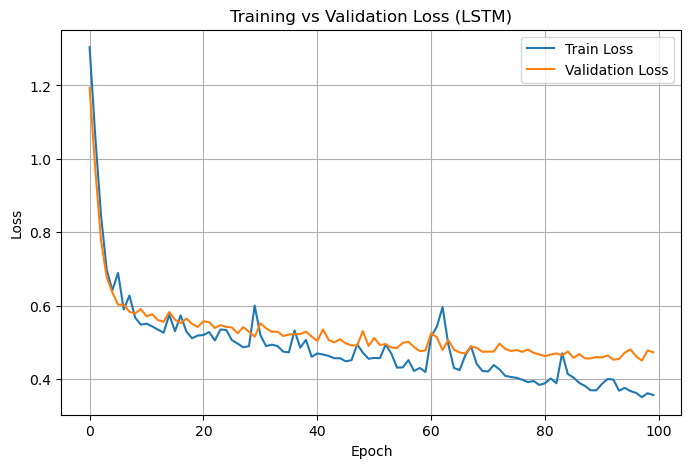

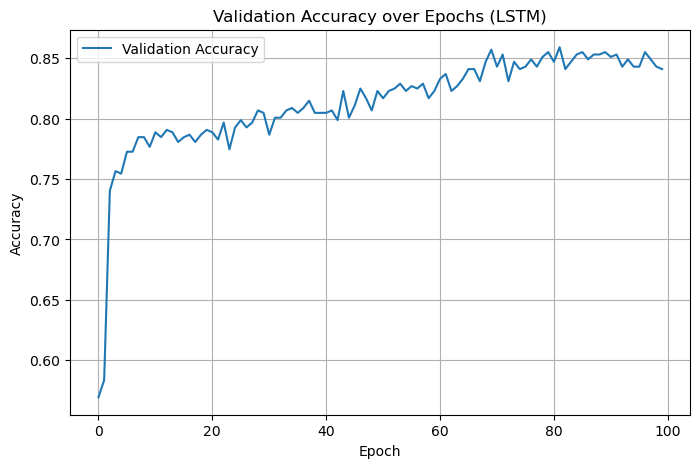

In [93]:
# Cell 9: Plot training vs validation loss

plt.figure(figsize=(8, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (LSTM)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs (LSTM)')
plt.legend()
plt.grid(True)
plt.show()


Test Accuracy: 0.5583
Test Top-3 Accuracy: 0.9708

Classification report:
              precision    recall  f1-score   support

         0.0       0.38      0.96      0.54        23
         2.0       0.65      0.95      0.77        41
         3.0       0.96      0.44      0.60       154
         4.0       0.12      0.27      0.16        22

    accuracy                           0.56       240
   macro avg       0.53      0.65      0.52       240
weighted avg       0.77      0.56      0.58       240



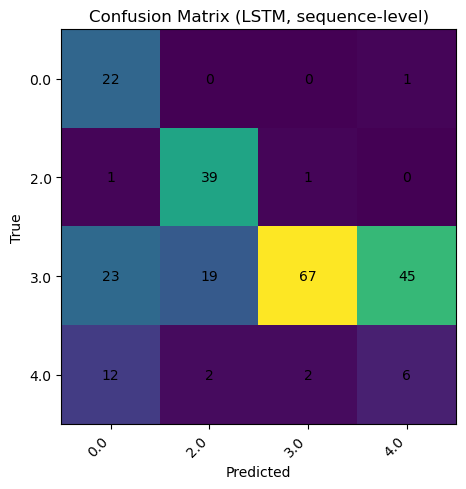

In [94]:
# Cell 10: Evaluate on TEST sequences

model.eval()
with torch.no_grad():
    test_logits = model(X_test_t)
    test_probs = torch.softmax(test_logits, dim=1).cpu().numpy()
    pred_labels = test_probs.argmax(axis=1)

y_true = y_test_t.cpu().numpy()

acc = accuracy_score(y_true, pred_labels)
top3 = top_k_accuracy_score(y_true, test_probs, k=min(3, num_classes))

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Top-3 Accuracy: {top3:.4f}\n")

target_names = list(label_encoder.classes_)
print("Classification report:")
print(classification_report(y_true, pred_labels, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_true, pred_labels)
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (LSTM, sequence-level)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=np.arange(len(target_names)), labels=target_names, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(target_names)), labels=target_names)

for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')

plt.tight_layout()
plt.show()
